In [11]:
import numpy as np
from BPnumba.ABCnum import DABC,createDABC
from BPnumba.GeneticOperators import InstancePob,CreatePoblation,CreateHeuristicPob
import matplotlib.pyplot as plt
from BPmodule.BPGen  import PROBLEM2,PROBLEM3,PROBLEM4,PROBLEM5
from numba.typed import List as NumbaList
import random as rd
import numba as nb

In [12]:
P2A1 = PROBLEM2[0]
P2A2 = PROBLEM2[1]
P3A1 = PROBLEM3[0]
P3A2 = PROBLEM3[1]
P4A1 = PROBLEM4[0]
P4A2 = PROBLEM4[1]
P5A1 = PROBLEM5[0]
P5A2 = PROBLEM5[1]

In [13]:
contenedor =P2A1[0][0]
datos =P2A1[1]
idBoxes = np.arange(1,len(datos)+1,dtype=np.int64)
n=len(datos)
numItr = 500
num_pop= 50
poblation = CreateHeuristicPob(50, datos)

In [14]:
ColonyWorker = InstancePob(poblation,datos,contenedor)

In [15]:
abc = createDABC(num_pop,n)

In [16]:
abc.Train(numItr,ColonyWorker,datos,contenedor)

In [17]:
abc.BestInd.fi,n-abc.BestInd.load

(1.0, 0)

In [18]:
abc.BestInd.load

29

In [19]:
abc.BestInd.codeSolution

'|5|7|10|13|8|1|21|26|25|24|27|16|19|29|28|11|14|12|22|23|18|17|15|9|2|3|20|4|6|'

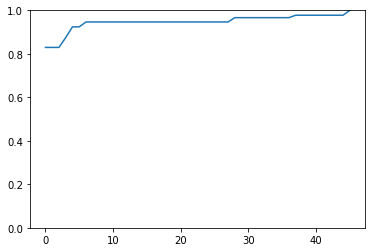

In [20]:
plt.figure()
plt.plot(abc.bestfi)
plt.ylim(0,1)
plt.show()